In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [2]:
def empirical_response(empirical_resp, stim_vals, x, stretch=1):
    stim_vals = stim_vals*stretch
    X = []
    for val in x:
        X.append(np.argmin(np.abs(stim_vals-val)))
    return empirical_resp[X]

def compute_entropy(probs):
    return -probs @ np.log2(probs)

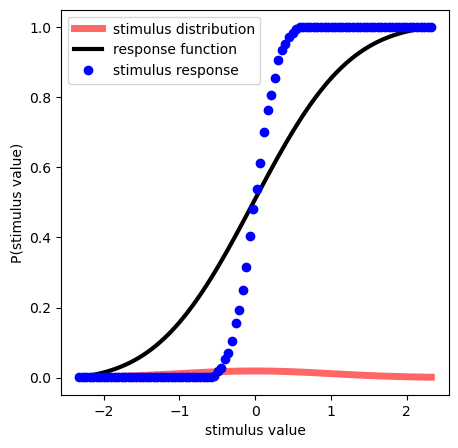

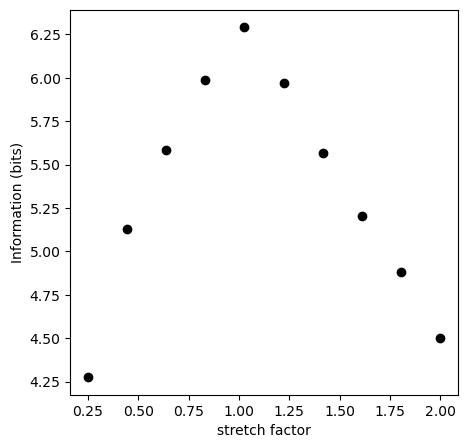

In [3]:
stim_vals = np.linspace(sp.stats.norm.ppf(0.01), sp.stats.norm.ppf(0.99), 100)
stim_dist = sp.stats.norm.pdf(stim_vals)/np.sum(sp.stats.norm.pdf(stim_vals))
empirical_resp = np.cumsum(stim_dist)
exp_stim_vals = stim_vals
exp_stim_resp = empirical_response(empirical_resp, stim_vals, exp_stim_vals, stretch=0.25)

plt.figure(figsize=(5, 5))
plt.plot(stim_vals, stim_dist, 'r-', lw=5, alpha=0.6, label='stimulus distribution')
plt.plot(stim_vals, empirical_resp, 'k-', lw=3, label='response function')
plt.plot(exp_stim_vals, exp_stim_resp, 'bo', lw=3, label='stimulus response')
plt.xlabel("stimulus value")
plt.ylabel("P(stimulus value)")
plt.legend()
plt.show()

# Show the information as a function of the stretch factor
stretch_factors = np.linspace(1/4, 2, 10)
entropies = np.zeros((len(stretch_factors),))

for i, stretch in enumerate(stretch_factors):
    exp_stim_resp = empirical_response(empirical_resp, stim_vals, exp_stim_vals, stretch=stretch)
    # remove diff = 0
    exp_stim_resp = exp_stim_resp[np.hstack((np.array(0), np.diff(exp_stim_resp)))>0]
    entropies[i] = compute_entropy(np.diff(exp_stim_resp))

plt.figure(figsize=(5,5))
plt.plot(stretch_factors, entropies, 'ko', lw=3)
plt.xlabel("stretch factor")
plt.ylabel("Information (bits)")
plt.show()